In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

true_images = np.concatenate([x_train, x_test], axis=0)
true_images = (np.expand_dims(true_images.astype(np.float32), axis=-1) - 127.5 )/127.5

true_labels = np.concatenate([y_train, y_test], axis=0)

print(true_images.shape, true_labels.shape)

NSAMP = true_images.shape[0]
NCLASS = 10

11493376/11490434 [==============================] - 0s 0us/step
(70000, 28, 28, 1) (70000,)


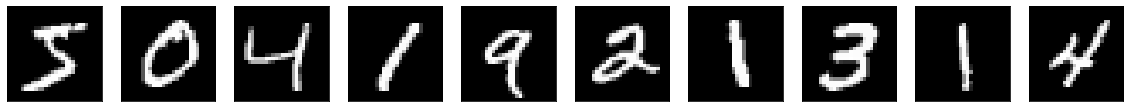

In [2]:
# FUNCTION FROM: Sundeep Rangan's Autoencorder Lab
def plot_images(Nrow, Ncol, image_size, channel, *image_list):
    plt.figure(figsize=(2*Ncol, 2*Nrow))
    for i in range(1,Ncol+1):
        for j in range(len(image_list)):
            ax = plt.subplot(len(image_list), Ncol, i+j*Ncol)
            if(channel==1):
                plt.imshow(image_list[j][i-1].reshape(image_size, image_size))
            else:
                plt.imshow(image_list[j][i-1].reshape(image_size, image_size, channel))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()
    
r = np.random.randint(0, NSAMP, size=10)
plot_images(1, r.shape[0], 28, 1, true_images)

In [28]:
from tensorflow.keras.layers import (Input, Dense, Conv2D, MaxPool2D, Flatten, UpSampling2D, Conv2DTranspose,
Reshape, LeakyReLU, BatchNormalization, Dropout)
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomNormal

tf.keras.backend.clear_session()

opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=.5)
act = 'linear'

def Conv(x, f, k, s, pad='same'):
    x = Conv2D(f, (k,k), activation=act, padding=pad, strides = (s,s), kernel_initializer=RandomNormal(stddev=0.02))(x)
    #x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    return x
  
def UpConv(x, f, k, s):
    x = UpSampling2D((s,s))(x)
    x = Conv(x, f, k, 1)
    x = Dropout(.3)(x)
    return x

def DeConv(x, f, k, s, pad='same'):
    x = Conv2DTranspose(f, (k,k), activation=act, padding=pad, strides = (s,s), kernel_initializer=RandomNormal(stddev=0.02))(x)
    #x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    return x

NOISE_DIM = NCLASS

gen_input = Input(shape=(NOISE_DIM))
def Generator(x):
    x = Dense(7*7*128, activation=act, kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = LeakyReLU(0.2)(x)
    x = Reshape((7,7,128))(x)
    x = UpConv(x, 64, 5, 2)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(1, (5,5), activation='tanh', padding='same')(x)
    #x = Conv2DTranspose(1, (5,5), activation='tanh', padding='same', strides=(1,1))(x)
    return x

generator = Model(gen_input, Generator(gen_input), name='Generator')
generator.compile(optimizer=opt, loss='binary_crossentropy')
# generator.summary()

# true/false input image classification
disc_input = Input(shape=(28,28,1))
def Discriminator(x):
    x = Conv(x, 64, 5, 2)
    x = Conv(x, 128, 5, 2)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    return x

discriminator = Model(disc_input, Discriminator(disc_input), name='Discriminator')
discriminator.compile(optimizer=opt, loss='binary_crossentropy')
#discriminator.summary()

# GAN
discriminator.trainable = False
ganInput = gen_input
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(ganInput, ganOutput, name='GAN')
gan.compile(optimizer=opt, loss='binary_crossentropy')
gan.summary()

Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
Generator (Model)            (None, 28, 28, 1)         275457    
_________________________________________________________________
Discriminator (Model)        (None, 1)                 212865    
Total params: 488,322
Trainable params: 275,457
Non-trainable params: 212,865
_________________________________________________________________


In [0]:
def getNoise(label):
    std_notlabel = 1e-3
    std_label  = 1
    
    N = label.shape[0]

    r = np.arange(NCLASS)
    x = np.random.randn(N,NCLASS)
    
    for i in np.arange(N):
        L = label[i]
        x[i,L] = std_label*x[i,L]
        x[i,r!=L] = std_notlabel*x[i,r!=L]
    return x

In [0]:
from tqdm import tqdm_notebook

def trainGAN(epochs, bs):
    niters = int(NSAMP/bs)
    
    dloss = np.empty(epochs*niters)
    gloss = np.empty(epochs*niters)
    
    i = 0
    for e in np.arange(1,epochs+1):
        with tqdm_notebook(range(niters)) as t:
            for _ in t:
                t.set_description('EPOCH: %0d' % e)

                noise_labels = np.random.randint(0,NCLASS, size=(bs))
                noise_input = getNoise(noise_labels)
                
                #noise_input = np.random.normal(0, 1, size=[bs, NOISE_DIM])
                x_fake = generator.predict(noise_input)
                choices = np.random.randint(0, NSAMP, size=bs)
                x_true = true_images[choices]

                x_batch = np.concatenate([x_fake, x_true])
                y_batch = np.zeros(2*bs)
                y_batch[bs:] = .9

                # train discriminator to MINIMIZE
                discriminator.trainable = True
                dloss[i] = discriminator.train_on_batch(x_batch, y_batch)

                # train generator to MAXIMIZE
                discriminator.trainable = False
                noise_labels = np.random.randint(0,NCLASS, size=(bs))
                noise_input = getNoise(noise_labels)
                #noise_input = np.random.normal(0, 1, size=[bs, NOISE_DIM])
                gloss[i] = gan.train_on_batch(noise_input, np.ones(bs))
                
                t.set_postfix(gloss=gloss[i], dloss=dloss[i])
                i+=1 #increase iteration 

In [35]:
EPOCHS = 40
BATCH_SIZE = 128 # really this x2

trainGAN(EPOCHS, BATCH_SIZE)

[4 1 5 6 4 8 0 4 2 2]


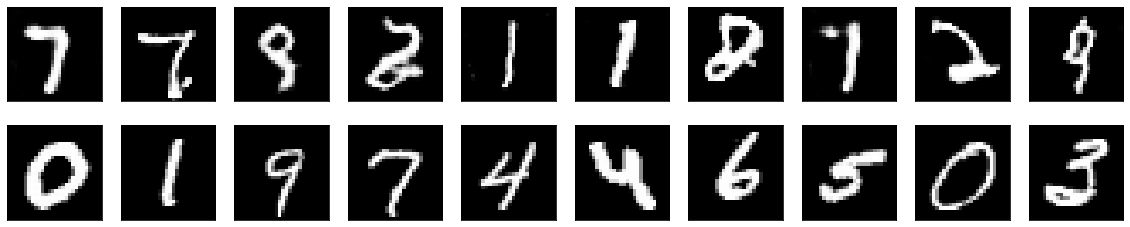

In [36]:
noise_labels = np.random.randint(0,NCLASS, size=10)
noise_input = getNoise(noise_labels)
pred = generator.predict(noise_input)
choices = np.random.randint(0, NSAMP, size=10)

print(noise_labels)
plot_images(2, noise_input.shape[0], 28, 1, pred, true_images[choices])